In [9]:
import argparse
import treegp
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
from sklearn.gaussian_process.kernels import Kernel
import os
import treecorr

# plotting things
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

def comp_2pcf_treecorr(x, y, k, bin_type='TwoD'):
    """measure the anisotropic 2pcf of some data."""
    cat = treecorr.Catalog(x=x, y=y, k=k, w=None)
    kk = treecorr.KKCorrelation(min_sep=0, max_sep=0.15, nbins=17,
                                bin_type=bin_type, bin_slop=0)
    kk.process(cat)

    return kk.xi

def raw_moments(im, ordx=1, ordy=1):

    posY, posX = np.indices(im.shape)
    posY = np.flipud(posY)
    
    rmom = sum(sum(im*posX**ordx*posY**ordy))
    
    return rmom

def centroids(im):
    M10 = raw_moments(im, ordx=1, ordy=0)
    M00 = raw_moments(im, ordx=0, ordy=0)
    M01 = raw_moments(im, ordx=0, ordy=1)
    xbar = M10/M00
    ybar = M01/M00
    return xbar, ybar
    
def cent_moments(im, ordx=1, ordy=1):
    posY, posX = np.indices(im.shape)
    posY = np.flipud(posY)
    
    xbar, ybar = centroids(im)
    
    cmom = sum(sum(im*(posX-xbar)**ordx*(posY-ybar)**ordy))
    
    return cmom

def get_theta(g1, g2):
    # this give theta in degrees
    phi = np.arctan2(g2,g1)*180/np.pi
    if g1*g2> 0:
        #first, quadrant
        if g1 > 0:
            phi = phi
        #third quadrant
        else: 
            phi = phi+360
    # second quadrant
    elif g1 < 0 and g2 > 0:
        phi = phi
    # fouth quadrant
    elif g1 > 0 and g2 < 0:
        phi = phi+360 
    theta = phi/2
    return theta

def get_orient(im):
    xbar, ybar = centroids(im)
    M20 = raw_moments(im, ordx=2, ordy=0)
    M00 = raw_moments(im, ordx=0, ordy=0)
    M02 = raw_moments(im, ordx=0, ordy=2)
    M11 = raw_moments(im, ordx=1, ordy=1)
    
    mu20p = M20/M00 - xbar**2
    mu02p = M02/M00 - ybar**2
    mu11p = M11/M00 - xbar*ybar
    
    #angle in degrees
    theta = get_theta(mu20p-mu02p,2*mu11p)
    return theta

In [10]:
seeds = list(range(6,11))+[22,23,25,26,27]+list(range(30,40))
seeds +=list(range(42,54))+list(range(55,61))+list(range(62,90))
seeds += list(range(90,130))

In [11]:
theta_dsigmaP, theta_e1P, theta_e2P = {}, {}, {}
for seed in seeds:
    d = pickle.load(open("..//runsims//sameheightPsfws//outh_psfws_"+str(seed)+".pkl", 'rb'))
    #d = pickle.load(open("..//runsims//sameheightRand//outh_rand_"+str(seed)+".pkl", 'rb'))

    for k in ['e1', 'e2', 'thx', 'thy', 'sigma']:
        locals()[k] = np.array(d[k])
    d_sigma = sigma - np.mean(sigma)

    xi_dsigma  = comp_2pcf_treecorr(thx, thy, d_sigma)
    xi_e1 = comp_2pcf_treecorr(thx, thy, e1)
    xi_e2 = comp_2pcf_treecorr(thx, thy, e2)

    theta_dsigmaP[seed] = get_orient(xi_dsigma)
    theta_e1P[seed] = get_orient(xi_e1)
    theta_e2P[seed] = get_orient(xi_e2)
    
theta_dsigmaR, theta_e1R, theta_e2R = {}, {}, {}
for seed in seeds:
    d = pickle.load(open("..//runsims//sameheightRand//outh_rand_"+str(seed)+".pkl", 'rb'))
    #d = pickle.load(open("..//runsims//sameheightRand//outh_rand_"+str(seed)+".pkl", 'rb'))

    for k in ['e1', 'e2', 'thx', 'thy', 'sigma']:
        locals()[k] = np.array(d[k])
    d_sigma = sigma - np.mean(sigma)

    xi_dsigma  = comp_2pcf_treecorr(thx, thy, d_sigma)
    xi_e1 = comp_2pcf_treecorr(thx, thy, e1)
    xi_e2 = comp_2pcf_treecorr(thx, thy, e2)

    theta_dsigmaR[seed] = get_orient(xi_dsigma)
    theta_e1R[seed] = get_orient(xi_e1)
    theta_e2R[seed] = get_orient(xi_e2)

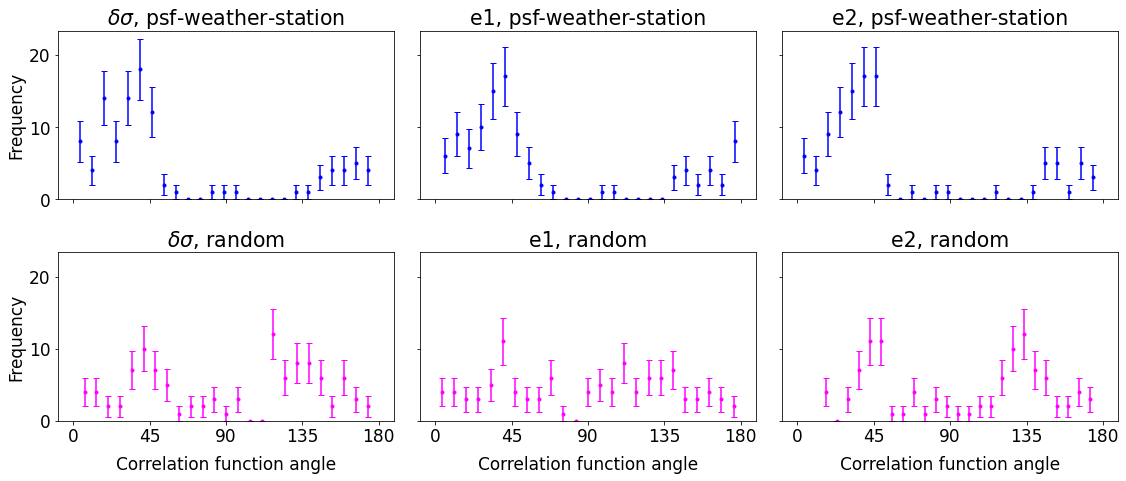

In [12]:
def plothist(ax,para,clr):
    y, bin_edges, _ = ax.hist(para, bins=binn, histtype='step', color="white")
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(
        bin_centers,
        y,
        yerr = y**0.5,
        marker = '.', drawstyle="steps-mid",
        linestyle ="",capsize=3, color=clr)
    return ax
    
plt.rcParams['font.size'] = 17
plt.rcParams['axes.labelsize'] = 17

paraP = [theta_dsigmaP.values(), theta_e1P.values(), theta_e2P.values()]
paraR = [theta_dsigmaR.values(), theta_e1R.values(), theta_e2R.values()]

fig,ax =plt.subplots(2,3,figsize=(16,7), sharey=True, sharex=True)
binn = 25

for i in range(3):
    ax[0,i] = plothist(ax[0,i], paraP[i],'blue')
    ax[1,i] = plothist(ax[1,i], paraR[i], 'magenta')

ax[0,0].set_title("$\delta\sigma$, psf-weather-station")
ax[1,0].set_title("$\delta\sigma$, random")
ax[0,1].set_title("e1, psf-weather-station")
ax[1,1].set_title("e1, random")
ax[0,2].set_title("e2, psf-weather-station")
ax[1,2].set_title("e2, random")

[a.set_xlabel("Correlation function angle", labelpad=10) for a in ax[1]]
[ax[i,0].set_ylabel("Frequency") for i in range(2)]
ax[0,0].set_xticks(np.linspace(0,180,5))

fig.tight_layout()

In [19]:
theta_e2R

{6: 142.96528099353773,
 7: 135.50210508226613,
 8: 155.89810113670237,
 9: 166.06602587165233,
 10: 41.2099603287905,
 22: 43.30997915543921,
 23: 43.42411799863008,
 25: 43.01017073021496,
 26: 47.8689926829419,
 27: 125.20295025517706,
 30: 73.8733298554132,
 31: 140.61213968254597,
 32: 127.7759636931944,
 33: 48.053978920910225,
 34: 33.66135322170486,
 35: 17.07507019144284,
 36: 79.81895658834864,
 37: 35.76869227305906,
 38: 26.911526417002893,
 39: 91.81587346647983,
 42: 40.970193125785734,
 43: 44.55912008452303,
 44: 56.03928619331936,
 45: 115.49499561484294,
 46: 47.34517096234205,
 47: 46.738260404008116,
 48: 124.65784048441122,
 49: 139.05939931869898,
 50: 48.600323003517985,
 51: 123.51028414810023,
 52: 164.0232033789839,
 53: 103.19774042390371,
 55: 109.90978878424698,
 56: 134.91626723114274,
 57: 86.36471383803459,
 58: 141.26183628683526,
 59: 120.68813495055754,
 60: 120.08606521986476,
 62: 48.39896731965393,
 63: 34.193102708402634,
 64: 71.43833309273194,
 